# Convert zmap to geotiff

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import netCDF4
import rasterio
import os
from scipy.interpolate import RegularGridInterpolator

%matplotlib inline

In [2]:
zfile_directory = "../Zipped zmap surfaces/Zipped zmap surfaces/"
output_geotiff_directory = "../data/GAB_surfaces/GeoTiff/"
output_numpy_directory = "../data/GAB_surfaces/NumPy/"
output_png_directory = "../data/GAB_surfaces/png/"

filenames = sorted(os.listdir(zfile_directory))
n_files = len(filenames)

list(zip(range(n_files), filenames))

[(0, 'AUSBATH09_AMG55_GDA94_500m_model_extent_zmap.dat'),
 (1, 'Base_Cenozoic_v19_zmap.dat'),
 (2, 'DEM_AUSTBATH_2009_zmap.dat'),
 (3, 'W050_EYRE_v3_zmap.dat'),
 (4, 'W080_BASE_CENOZOIC_v19_20km_ANU_zmap.dat'),
 (5, 'W100_BASE_MACKUNDA_v13_zmap.dat'),
 (6, 'W130_COREENA_v9_zmap.dat'),
 (7, 'W210_BUNGIL_v8_zmap.dat'),
 (8, 'W220_MOOGA_v5_zmap.dat'),
 (9, 'W230_ORALLO_v4_zmap.dat'),
 (10, 'W240_GUBBERA_v9_zmap.dat'),
 (11, 'W310_WESTBOURNE_v6_zmap.dat'),
 (12, 'W330_SPRINGBOK_v5_zmap.dat'),
 (13, 'W410_SPUNCON_v5_zmap.dat'),
 (14, 'W480_DURABILLA_v4_zmap.dat'),
 (15, 'W510_HUTUP_v16_zmap.dat'),
 (16, 'W540_EVERUP_v11_zmap.dat'),
 (17, 'W580_PRECLOW_POOLOWANNA_v2_zmap.dat'),
 (18, 'W610_BUNCON_BJ_v24_isopach_with_W810_PCTOP_v3_zmap.dat'),
 (19, 'W610_BUNCON_BJ_v24_zmap.dat'),
 (20, 'W810_PCTOP_v3_isopach_with_W910_BASEMENT_v1_zmap.dat'),
 (21, 'W810_PCTOP_v3_zmap.dat'),
 (22, 'W910_BASEMENT_v1_zmap.dat')]

In [3]:
epsg = 28355

# define CRS as GDA94 MGA55
crs = rasterio.crs.CRS.from_dict(init='epsg:'+str(epsg))

Ensure each grid is the same shape and extent

In [4]:


all_shapes  = np.zeros((n_files, 2), dtype=int)
all_extents = np.zeros((n_files, 4))


for i, zfilename in enumerate(filenames):
    z_file = rasterio.open(zfile_directory+zfilename)
    all_extents[i] = z_file.bounds.left, z_file.bounds.right, z_file.bounds.bottom, z_file.bounds.top
    all_shapes[i]  = z_file.shape
    z_file.close()
    
    print("{:02d} {} {} {}".format(i, tuple(all_shapes[i]), all_extents[i], zfilename[:4]))

00 (5162, 3982) [-955306.1733 1035193.8267 6342199.3349 8922699.3349] AUSB
01 (5162, 3982) [-955637.8812 1034862.1188 6342298.2975 8922798.2975] Base
02 (6122, 5228) [-1285305.7128  1329194.2872  6008182.5165  9069682.5165] DEM_
03 (5162, 3982) [-955637.8812 1034862.1188 6342298.2975 8922798.2975] W050
04 (131, 101) [-955637.8812 1044362.1188 6342298.2975 8942298.2975] W080
05 (5162, 3982) [-955637.8812 1034862.1188 6342298.2975 8922798.2975] W100
06 (5162, 3982) [-955637.8812 1034862.1188 6342298.2975 8922798.2975] W130
07 (5162, 3982) [-955637.8812 1034862.1188 6342298.2975 8922798.2975] W210
08 (5162, 3982) [-955637.8812 1034862.1188 6342298.2975 8922798.2975] W220
09 (5162, 3982) [-955637.8812 1034862.1188 6342298.2975 8922798.2975] W230
10 (5162, 3982) [-955637.8812 1034862.1188 6342298.2975 8922798.2975] W240
11 (5162, 3982) [-955637.8812 1034862.1188 6342298.2975 8922798.2975] W310
12 (5162, 3982) [-955637.8812 1034862.1188 6342298.2975 8922798.2975] W330
13 (5162, 3982) [-95563

In [5]:
# Pick an optimal shape

idx = 5

z_file = rasterio.open(zfile_directory+filenames[idx])
z_data = z_file.read(1, masked=True)
global_mask = z_data.mask.copy()
global_extent = z_file.bounds.left, z_file.bounds.right, z_file.bounds.bottom, z_file.bounds.top
global_shape  = tuple(z_file.shape)
global_transform = z_file.transform
z_file.close()

print("Resample zmaps to {:s}\n  shape: {}, \n extent: {}".format(filenames[idx],
                                                            global_shape,
                                                            global_extent))


Resample zmaps to W100_BASE_MACKUNDA_v13_zmap.dat
  shape: (5162, 3982), 
 extent: (-955637.8812, 1034862.1188, 6342298.2975, 8922798.2975)


In [6]:
xcoords, dx = np.linspace(global_extent[0], global_extent[1], global_shape[1], endpoint=False, retstep=True)
ycoords, dy = np.linspace(global_extent[2], global_extent[3], global_shape[0], endpoint=False, retstep=True)

xq, yq = np.meshgrid(xcoords, ycoords)

In [7]:
def fill_ndimage(data,invalid=None):
    """
    Replace the value of invalid 'data' cells (indicated by 'invalid')
    by the value of the nearest valid data cell
    """
    from scipy.ndimage import distance_transform_edt
    masked_array = hasattr(data, "fill_value")
    if masked_array:
        mask_fill_value = data.data == data.fill_value
        data = data.data.copy()
        data[mask_fill_value] = np.nan
    else:
        data = data.copy()

    if invalid is None:
        invalid = np.isnan(data)
        if masked_array:
            invalid += mask_fill_value
    ind = distance_transform_edt(invalid, return_distances=False, return_indices=True)
    return data[tuple(ind)]

In [8]:
for zfilename in filenames:
    # import surface
    z_file = rasterio.open(zfile_directory+zfilename)
    z_data = z_file.read(1, masked=True)
    extent = z_file.bounds.left, z_file.bounds.right, z_file.bounds.bottom, z_file.bounds.top
    name = zfilename[:-9] # remove '_zmap.dat'

    # check the shape and bounding box
    if z_data.shape != global_shape or extent != global_extent:
        print(" - Resampling", name)
        # resample
        xc = np.linspace(extent[0], extent[1], z_file.shape[1], endpoint=False)
        yc = np.linspace(extent[2], extent[3], z_file.shape[0], endpoint=False)

         # remove mask and fill NaNs
        z_array = fill_ndimage(z_data)

        # interpolate to global grid
        rgi = RegularGridInterpolator((yc, xc), z_array, bounds_error=False, fill_value=None)
        z_data_interp = rgi((yq, xq), method='linear')
        
#         # hacky way to make sure we get no NaNs at the edges of some arrays
#         z_data_nearest = rgi((yq, xq), method='nearest')
#         mask_NaNs = np.isnan(z_data_interp)
#         z_data_interp[mask_NaNs] = z_data_nearest[mask_NaNs]
        
        # z_data_interp[global_mask] = z_file.nodata
        z_data = np.ma.array(data=z_data_interp, mask=global_mask)


    # create a plot
    fig = plt.figure(figsize=(10,10))
    ax1 = fig.add_subplot(111, title=name)
    im1 = ax1.imshow(z_data, extent=global_extent)
    fig.colorbar(im1)
    fig.savefig(output_png_directory+name+'.png', bbox_inches='tight', dpi=300)
    plt.close(fig)


    # save geotiff
    with rasterio.open(output_geotiff_directory+name+'.tiff', 'w', driver='GTiff',
                       height=global_shape[0], width=global_shape[1],
                       count=1, dtype=z_data.dtype, nodata=z_file.nodata,
                       crs=crs, transform=global_transform, GDAL_TIFF_INTERNAL_MASK=True) as gtif:
        z_data_gtif = z_data.copy()
        z_data_gtif.data[global_mask] = z_file.nodata
        gtif.write(z_data_gtif, 1)
    
    
    # save numpy
    np.savez_compressed(output_numpy_directory+name+'.npz',
                       data=z_data.data, mask=z_data.mask, extent=global_extent, x=xcoords, y=ycoords)
    
    # close zmap
    z_file.close()
    
    print("Finished {}".format(name))


 - Resampling AUSBATH09_AMG55_GDA94_500m_model_extent
Finished AUSBATH09_AMG55_GDA94_500m_model_extent
Finished Base_Cenozoic_v19
 - Resampling DEM_AUSTBATH_2009
Finished DEM_AUSTBATH_2009
Finished W050_EYRE_v3
 - Resampling W080_BASE_CENOZOIC_v19_20km_ANU
Finished W080_BASE_CENOZOIC_v19_20km_ANU
Finished W100_BASE_MACKUNDA_v13
Finished W130_COREENA_v9
Finished W210_BUNGIL_v8
Finished W220_MOOGA_v5
Finished W230_ORALLO_v4
Finished W240_GUBBERA_v9
Finished W310_WESTBOURNE_v6
Finished W330_SPRINGBOK_v5
Finished W410_SPUNCON_v5
Finished W480_DURABILLA_v4
Finished W510_HUTUP_v16
Finished W540_EVERUP_v11
 - Resampling W580_PRECLOW_POOLOWANNA_v2
Finished W580_PRECLOW_POOLOWANNA_v2
 - Resampling W610_BUNCON_BJ_v24_isopach_with_W810_PCTOP_v3
Finished W610_BUNCON_BJ_v24_isopach_with_W810_PCTOP_v3
 - Resampling W610_BUNCON_BJ_v24
Finished W610_BUNCON_BJ_v24
 - Resampling W810_PCTOP_v3_isopach_with_W910_BASEMENT_v1
Finished W810_PCTOP_v3_isopach_with_W910_BASEMENT_v1
 - Resampling W810_PCTOP_v3
F

## Grid AusMoho

In [44]:
def transform_coordinates(x, y, epsg_in, epsg_out):
    """
    Transform between any coordinate system.
    **Requires `pyproj`** - install using pip.
    Args:
        x : float / 1D array
            x coordinates (may be in degrees or metres/eastings)
        y : float / 1D array
            y coordinates (may be in degrees or metres/northings)
        epsg_in : int
            CRS of x and y coordinates
        epsg_out : int
            CRS of output
    Returns:
        x_out : float / list of floats
            x coordinates projected in `epsg_out`
        y_out : float / list of floats
            y coordinates projected in `epsg_out`
    """
    import pyproj

    proj_in = pyproj.CRS("EPSG:" + str(epsg_in))
    proj_out = pyproj.CRS("EPSG:" + str(epsg_out))
    transformer = pyproj.Transformer.from_crs(proj_in, proj_out, always_xy=True)
    return transformer.transform(x,y)


AusMoho = np.loadtxt("../AuSREM-CM-moho/AusMoho2012.xyz/AusMoho2012.xyz")

# convert lon/lat to eastings/northings
moho_lon = AusMoho[:,1]
moho_lat = AusMoho[:,0]

moho_eastings, moho_northings = transform_coordinates(moho_lon, moho_lat, 4326, 28355)


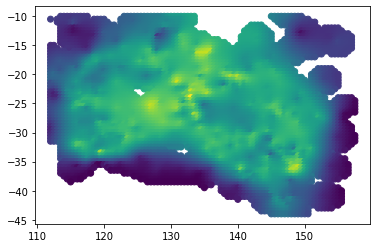

In [53]:
plt.scatter(moho_lon, moho_lat, c=AusMoho[:,2])

In [65]:
import stripy
mesh = stripy.Triangulation(moho_eastings, moho_northings)

moho_z, ierr = mesh.interpolate(xq.ravel(), yq.ravel(), AusMoho[:,2])

moho_z_grid = np.flipud(moho_z.reshape(xq.shape)) * -1e3

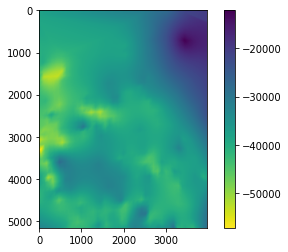

In [67]:
plt.imshow(moho_z_grid, cmap='viridis_r')
plt.colorbar()

In [68]:
# save geotiff
with rasterio.open(output_geotiff_directory+'AusMoho_grid.tiff', 'w', driver='GTiff',
                   height=global_shape[0], width=global_shape[1],
                   count=1, dtype=z_data.dtype, nodata=z_file.nodata,
                   crs=crs, transform=global_transform, GDAL_TIFF_INTERNAL_MASK=True) as gtif:
    gtif.write(moho_z_grid.astype(float), 1)


# save numpy
np.savez_compressed(output_numpy_directory+'AusMoho_grid.npz',
                   data=moho_z_grid, mask=np.ones_like(moho_z_grid, dtype=bool),
                   extent=global_extent, x=xcoords, y=ycoords)